# Vehicle-Detection
------


## External Modules for Project 
----

In [3]:
import numpy as np
import cv2
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import glob
from pathlib import Path
import pickle
import imageio
# imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Load/Save Helper Functions
----

In [5]:
def load_saved_data(data_path):
    data_path_chk = Path(data_path).is_file()
    if data_path_chk:
        with open(data_path,'rb') as fp:
            saved_data = pickle.load(fp)
        return saved_data
    else:
         raise LookupError("can't find {}".format(data_path))


def save_data_to_path(data_path, data):
    with open(data_path, 'wb') as fp:
        pickle.dump(data, fp)

## Data Loading
----
 The data can be seperated as **vehicle** and **non-vehicle** objects, that data files can be downloaded in [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip). After download the zip files, extract the files under directry of **./test_images/**. Since we are using sklearn for the project which doesn't support GPU computation, we will limit the amount of training and testing data to prevent the features extraction and model prediction taking too long. 

In [6]:
# Divide up into vehicle and vehicles
vehicle_images_path = glob.glob('./test_images/vehicles/**/*.png')
non_vehicle_images_path = glob.glob('./test_images/non-vehicles/**/*.png')

vehicle_imgs = []
non_vehicle_imgs = []

read_img = lambda img_path: cv2.imread(img_path)

for image in vehicle_images_path:
    img = read_img(image)
    vehicle_imgs.append(img)
for image in non_vehicle_images_path:
    img = read_img(image)
    non_vehicle_imgs.append(img)

# we only using 2000 vehicle and non-vehicle data 
n_data = 2000 

# random select vehicle and non-vehicle objects
random_select_vehicle_imgs = random.sample(vehicle_imgs, n_data)
random_select_non_vehicle_imgs = random.sample(non_vehicle_imgs, n_data)

# create the data and labels for the dataset(traing+testing) 
# since the two catagorties are well seperated, we labeled vehicle as 1 and 0 otherwise
data_set = random_select_vehicle_imgs+random_select_non_vehicle_imgs
data_set_labels = [1 if idx<len(random_select_vehicle_imgs) else 0 for idx in range(len(data_set))]

print("total number of vehicles {}".format(len(vehicle_imgs)))
print("total number of non-vehicles {}".format(len(non_vehicle_imgs)))
print("total number of object {}".format(len(data_set)))
print("total number of object labels {}".format(len(data_set_labels))) 


total number of vehicles 8792
total number of non-vehicles 8968
total number of object 4000
total number of object labels 4000


## Image Features
----
There are three types of image features that we care about in this project. There are spatial (resize), color histrogram, and Oriented Gradient (HOG) 


In [8]:
# color space feature, convert an image to specified color space and size
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### some extra features helper functions 

In [9]:
#extract HOG of image from specified channel(s)
def extract_hog_features(feature_image, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
   
    return np.array(hog_features)


def convert_clr(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    else: feature_image = np.copy(image)     
    return feature_image

### global parameters for features extraction  
These parameter are mostly for tuning the model 

In [10]:
cspace='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" 

### tesing HOG features function
we tested the HOG features of both vehicle and non-vehicle objects for all channel

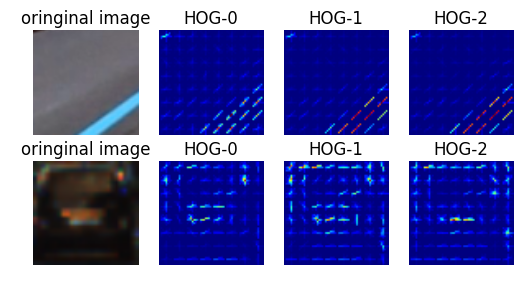

In [17]:
%matplotlib inline

selected_vehicle = random.choice(vehicle_imgs)
selected_non_vehicle = random.choice(non_vehicle_imgs)

def test_HOG(img):
    new_img = convert_clr(img)
    _, hog_img_ch0= get_hog_features(new_img[:,:,0], orient,pix_per_cell,cell_per_block, True)
    _, hog_img_ch1= get_hog_features(new_img[:,:,1], orient,pix_per_cell,cell_per_block, True)
    _, hog_img_ch2= get_hog_features(new_img[:,:,2], orient,pix_per_cell,cell_per_block, True)

    return [
            new_img,
            hog_img_ch0,
            hog_img_ch1,
            hog_img_ch2
            ]


output_imgs = [test_HOG(selected_vehicle), test_HOG(selected_non_vehicle)] 
ouput_labels = ["oringinal image", "HOG-0", "HOG-1", "HOG-2"]


fig = plt.figure()
for idx, cat in enumerate(output_imgs):
    for idx2, img in enumerate(cat):
        fig.add_subplot(idx+1,len(cat), idx2+1)
        plt.axis('off')
        plt.title(ouput_labels[idx2])
        plt.imshow(img)
        plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0)

## The model pipeline
---
we create the model pipeline using the concatenation(horizontal) of above features, then stacking(vertical) them up for all the training examples, then utilize **StandardScaler** from **sklearn** to nomalize the incoming data

During training, the model pipeline will generate a normalization base and the updated(after normalization) features of all the training examples. 

During testing, the testing example can either normailized by the normalization base from training, or it can be normalized by using normalization base that generate from both train and testing set. 

Strickly speaking, one should not generate new normalization base from testing, but only use nomrnalization base from training. In our case, the reason to use the new normalization base is that one can utilize the both train and test data are different from the one we use in the real image from the video stream, and also the dataset we use is relatively small

Also, we tested the video stream with two normalization bases, the performace impact is insinificant 

The above functionality is achieved by using the **partial_fit** method within **StandardScaler**

In [11]:
def model_pipeline(data,ttl_normalized_base=None, allow_partial_fit=True):
    
    ttl_fts = None

    for idx, obj in enumerate(data):
        
        feature_image = convert_clr(obj, cspace)
                        
        spatial_ft = bin_spatial(feature_image, size=spatial_size)
        
        hist_ft = color_hist(feature_image, nbins=hist_bins)
        
        HOG_ft = extract_hog_features(feature_image, orient, pix_per_cell, cell_per_block, hog_channel)
        
        ttl_ft = np.hstack((spatial_ft, hist_ft, HOG_ft))

        ttl_fts = np.vstack((ttl_fts,ttl_ft)).astype(np.float64) if idx>0 else ttl_ft.astype(np.float64)  
    
    if not (ttl_normalized_base):
        ttl_normalized_base = StandardScaler()
    
    if allow_partial_fit:
        ttl_normalized_base = ttl_normalized_base.partial_fit(ttl_fts)
    
    ttl_normalized_features = ttl_normalized_base.transform(ttl_fts)
    
    return ttl_normalized_base, ttl_normalized_features

### load/save normalization base and nomalized features

In [12]:
train_data_path = './train_data'
train_labels_path = './train_lables'
test_data_path = './test_data'
test_labels_path = './test_lables'
train_normalized_base_path = './train_normalized_base'
train_normalized_features_path = './train_normalized_features'
test_normalized_base_path = './test_normalized_base'
test_normalized_features_path = './test_normalized_features'

try:
    X_train,y_train = load_saved_data(train_data_path), load_saved_data(train_labels_path)
    X_test,y_test = load_saved_data(test_data_path), load_saved_data(test_labels_path)
    train_normalized_base = load_saved_data(train_normalized_base_path)
    train_normalized_features = load_saved_data(train_normalized_features_path)
    test_normalized_base = load_saved_data(test_normalized_base_path)
    test_normalized_features = load_saved_data(test_normalized_features_path)

    
except:
    all_data = X_train, X_test, y_train, y_test = train_test_split(
    data_set, data_set_labels, test_size=0.15, random_state=87)


    data_paths = [train_data_path, test_data_path, train_labels_path, test_labels_path]
    for path, data in zip(data_paths, all_data):
        save_data_to_path(path, data)
    
    
    train_normalized_base, train_normalized_features = model_pipeline(X_train)
    test_normalized_base, test_normalized_features = model_pipeline(X_test, train_normalized_base)
    save_pipelined_data = [train_normalized_base, train_normalized_features,
                           test_normalized_base, test_normalized_features]
   
    save_pipelined_paths = [train_normalized_base_path, train_normalized_features_path,
                            test_normalized_base_path, test_normalized_features_path]
    
    for path, data in zip(save_pipelined_paths, save_pipelined_data):
        save_data_to_path(path, data)

print("total number of training objects {}".format(len(X_train)))
print("total number of testing objects {}".format(len(X_test)))

total number of training objects 3400
total number of testing objects 600


## Training Model
-----
In here, we train a linear SVC model to classified vehicle and non-vehicle objects. 


12.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9967
SVC predicts:  [0 1 0 0 1 0 0 1 1 1]
For these 10 labels:  [0, 1, 0, 0, 1, 0, 0, 1, 1, 1]
0.01563 Seconds to predict 10 labels with SVC


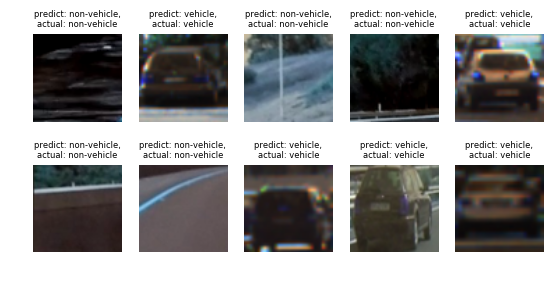

In [13]:
%matplotlib inline

svc_path = './svc_model'

t=time.time()

try:
    svc = load_saved_data(svc_path)
except:
    svc = LinearSVC()
    svc.fit(train_normalized_features, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(test_normalized_features, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
n_prediction=svc.predict(test_normalized_features[0:n_predict])
n_truth=y_test[0:n_predict]
print('SVC predicts: ',n_prediction )
print('For these',n_predict, 'labels: ', n_truth)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# lambda function that used for identify object type from number 
eval_sign = lambda num: "vehicle" if num==1 else "non-vehicle"

fig = plt.figure()
for idx in range(n_predict):
    fig.add_subplot((idx)/5+1,5, idx+1)
    plt.axis('off')
    plt.title("predict: {},\nactual: {}".format(eval_sign(n_prediction[idx]),
                                                           eval_sign(n_truth[idx])),fontsize=6)
    plt.imshow(X_test[idx])
    plt.subplots_adjust(left=0.05, right=0.9, top=1.2, bottom=0)



## Object indentification function

There are three main functions in here

**find_cars**: scale a region of interest(area that vehicle/non-vehicle appear offen) and then apply the features extraction as above, by going thru the region using sliding windows and classify each window, one can draw boex and record the coordinates of that box if a window has been classified as vehicle

**heatmap**: due to the fact that find_car might re-draw many duplicate region becasue of the silid window technique, one can use heatmap(add 1 to an area) on the identified area from coordinates that mentioned above then apply a threshold to filter out a region

**draw_box**: draw a box on the region that the heatmap identified


In [14]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient=orient, pix_per_cell=pix_per_cell, 
              cell_per_block=cell_per_block, spatial_size=spatial_size,
              hist_bins=hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255.0
    img_tosearch = img[ystart:ystop,:,:]  
    bounding_boxes = []
    ctrans_tosearch = convert_clr(img_tosearch, 'YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bounding_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img,bounding_boxes




def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



## Image/Video Process Pipeline
----

In [15]:
def image_process_pipeline(image, svc=svc, model_scaler=train_normalized_base):
    ystart = 400
    ystop = 656
    scale = 1.5
    threshold = 0.015
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    _, bounding_boxes = find_cars(image, ystart, ystop, scale, svc, model_scaler)
    
    heat = add_heat(heat, bounding_boxes)
    
    heat = apply_threshold(heat, threshold)
    
    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

def video_process_pipeline(image):
    img, _ =image_process_pipeline(image)
    return img

### test image pipeline 

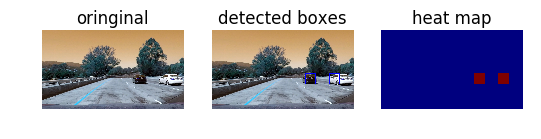

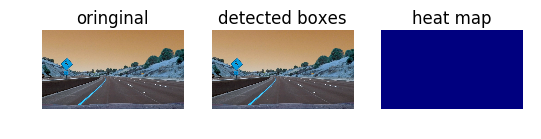

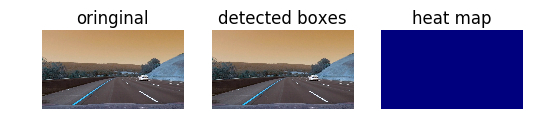

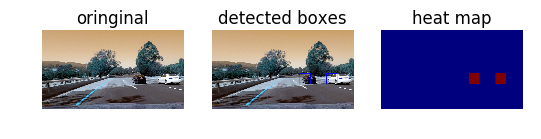

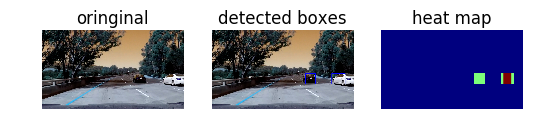

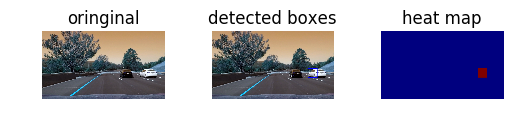

In [16]:
%matplotlib inline
test_images_path = glob.glob('./test_images/*.jpg')
titles = ["oringinal", "detected boxes" , "heat map"]

for ix, path in enumerate(test_images_path):
    image = read_img(path)
    draw_img, heatmap = image_process_pipeline(image)
    imgs = [image, draw_img, heatmap]
    fig = plt.figure()
    for ix2, img in enumerate(imgs):
        fig.add_subplot(ix+1, 3, ix2+1)
        plt.axis('off')
        plt.title(titles[ix2])
        plt.imshow(img)
        plt.subplots_adjust(left=0.1, right=0.9, top=1.2, bottom=0)



### test video pipeline

In [17]:
processed_output = 'output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(video_process_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(processed_output, audio=False)

[MoviePy] >>>> Building video output2.mp4
[MoviePy] Writing video output2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:15<00:00,  3.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output2.mp4 

Wall time: 6min 16s


## Conclusions:
----
This project we untilzed multiple feature vectors, linear SVM classifier together with some image manipulation techniques to identify objects within an image. While the whole pipeline can identify objects within a image most of the time, the pipeline also fail on some cases,which might due to the limited trainig size. Also, due to the nature of we applying threshold on an image to filter false positive, the ground truth boxes usuually cannot correctly contain the objects it identiify

To build a better pipeline, One should also consider technique that utilize nerual network(e.g:SSD, YOLO) 